In [1]:
# import all libraries
import pandas as pd
import seaborn as sns
import joblib
import datetime
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
import matplotlib as plt
from xgboost import plot_importance
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
import numpy as np
sns.set()

In [2]:
# Path settings


path_var = 1 

if (path_var == 1):
    filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
    modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


else:
    filepath = '/home/sharan/Desktop/Option_Pricing/datasets/'
    mdoelpath = '/home/sharan/Desktop/Option_Pricing/pickles/'



nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'
    
nfty_19 = filepath + 'NIFTY50_2019_feature_set_COV_complete.csv'
nfty_ecdf_19 = filepath + 'NIFTY50_2019_feature_set_ECDF_complete.csv'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 3                      #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage','strike','spot','opPrice']
    
    test_feats = pd.read_csv(nfty_ecdf_19)
    
else:
    feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    test_feats = pd.read_csv(nfty_19)
    
    if (approach == 2):
        dropNames= ['date', 'percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp',
                    'avg_atmError']
        
    else:
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        
###################




X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']
X = X.drop(dropNames, axis = 1)    





G = test_feats.iloc[:,:-1]
H = test_feats.loc[:,'Target']
G = G.drop(dropNames, axis = 1)  


# Port part handled at the end


Approach var set to :: 3


In [4]:
# Start the scaling process

featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)


G = scaler.transform(G)
G = pd.DataFrame(G, columns = featNames)


In [5]:
# # # Save the scalar file

# joblib.dump(scaler, modelpath + 'SCALER_NIFTY50_Expt' + str(approach) + '.model')
# print("Scaler saved to path ::", modelpath + 'SCALER_NIFTY50_Expt' + str(approach) + '.model')

In [6]:
# Removing the Random splits

X_train = X


X_test = G


Y_train = Y
Y_test = H



print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)

Y_test=Y_test.values
Y_train=Y_train.values


X & Y_Dim of Train is (13516, 19) (13516,)
X & Y_Dim of Test is (7667, 19) (7667,)


In [7]:
# param = 
model = XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.3, n_jobs=4)
%time model.fit(X_train, Y_train)
print(model)



CPU times: user 1min 24s, sys: 164 ms, total: 1min 24s
Wall time: 21.6 s
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [8]:
k = model.predict(X_test)

In [9]:
# Normalized Error Metric (NEM)
diff = []
bin_width = 0.1    # Note the uniform binning!!!!!!!!
dist_sum = 0
for i in range(len(k)):
    dist = abs(k[i] - Y_test[i])
    d = k[i] - Y_test[i]
    diff.append(d)
    dist_sum = dist_sum + dist
    
print("NEM :: ", (dist_sum*bin_width)/len(Y_test))

NEM ::  0.24182861614712406


In [10]:
accuracy_score(Y_test, k)*100
# print(classification_report(Y_test, k))

25.485848441372116

In [11]:
# u = {'C_i' : Y_test, 'P_i' : k, 'C_i-P_i': diff}
# g = pd.DataFrame(u)
# g.to_csv(filepath + 'XGB_COMPLETE_train_approach'+str(approach)+'_Cipi.csv', index = False)

In [12]:
def c_int(lst):
    df = pd.DataFrame(lst)
    df = df.sort_values(by = 0).reset_index(drop=True)
#    print(df)
    cp1 = df[np.logical_and(df[0] >= -2,df[0] <= 2)]
    return (len(cp1)/len(df)*100)

In [13]:
# Confidence interval value
lst = Y_test - k
round(1-c_int(lst)/100, 2)

0.29

In [14]:
# # Saving the model
# joblib.dump(model, modelpath + 'NIFTY50_Expt' + str(approach) + '.model')
# print("Model saved to path ::", modelpath + 'NIFTY50_Expt_NEW' + str(approach) + '.model' )

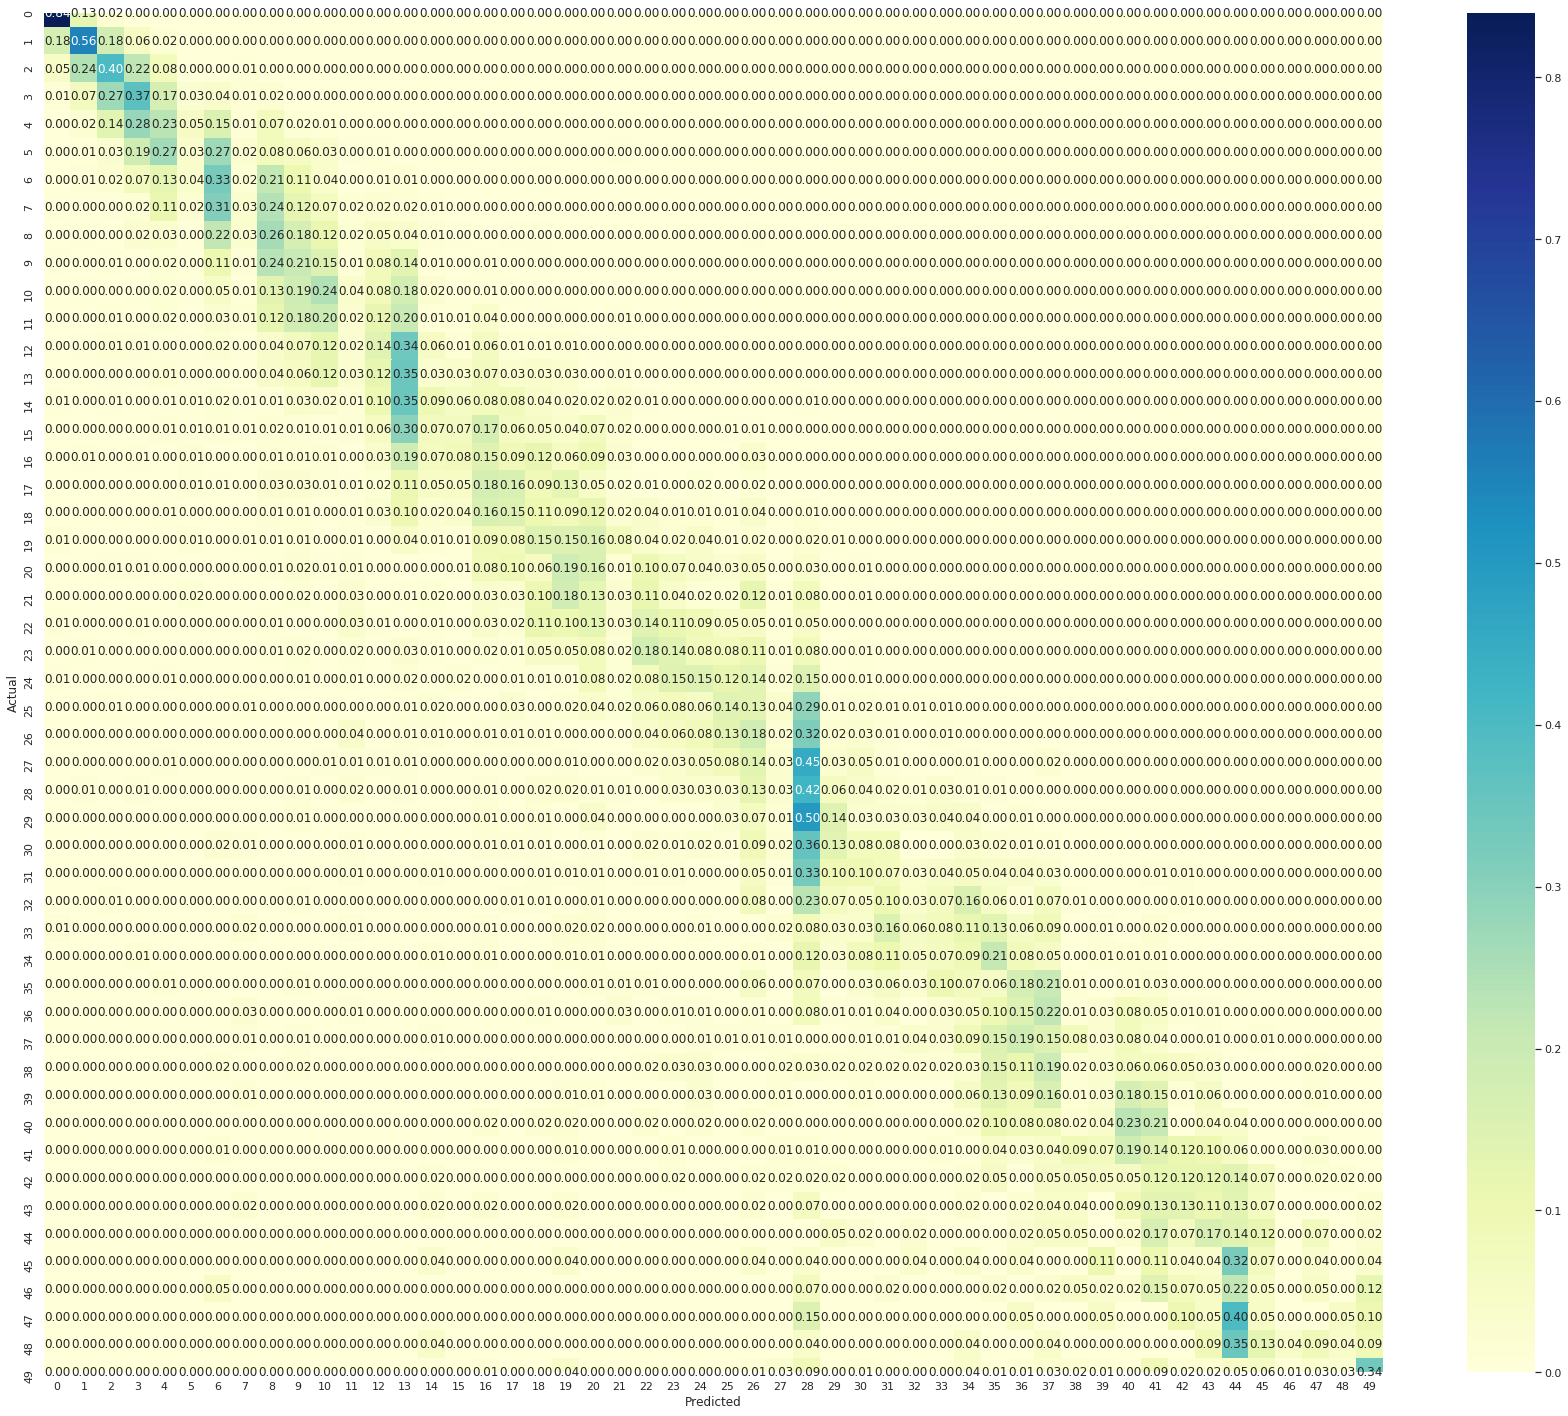

In [15]:
cm = confusion_matrix(Y_test, k)
# Normalise
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,25))
sns.heatmap(cmn, annot=True, fmt='.2f',  cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

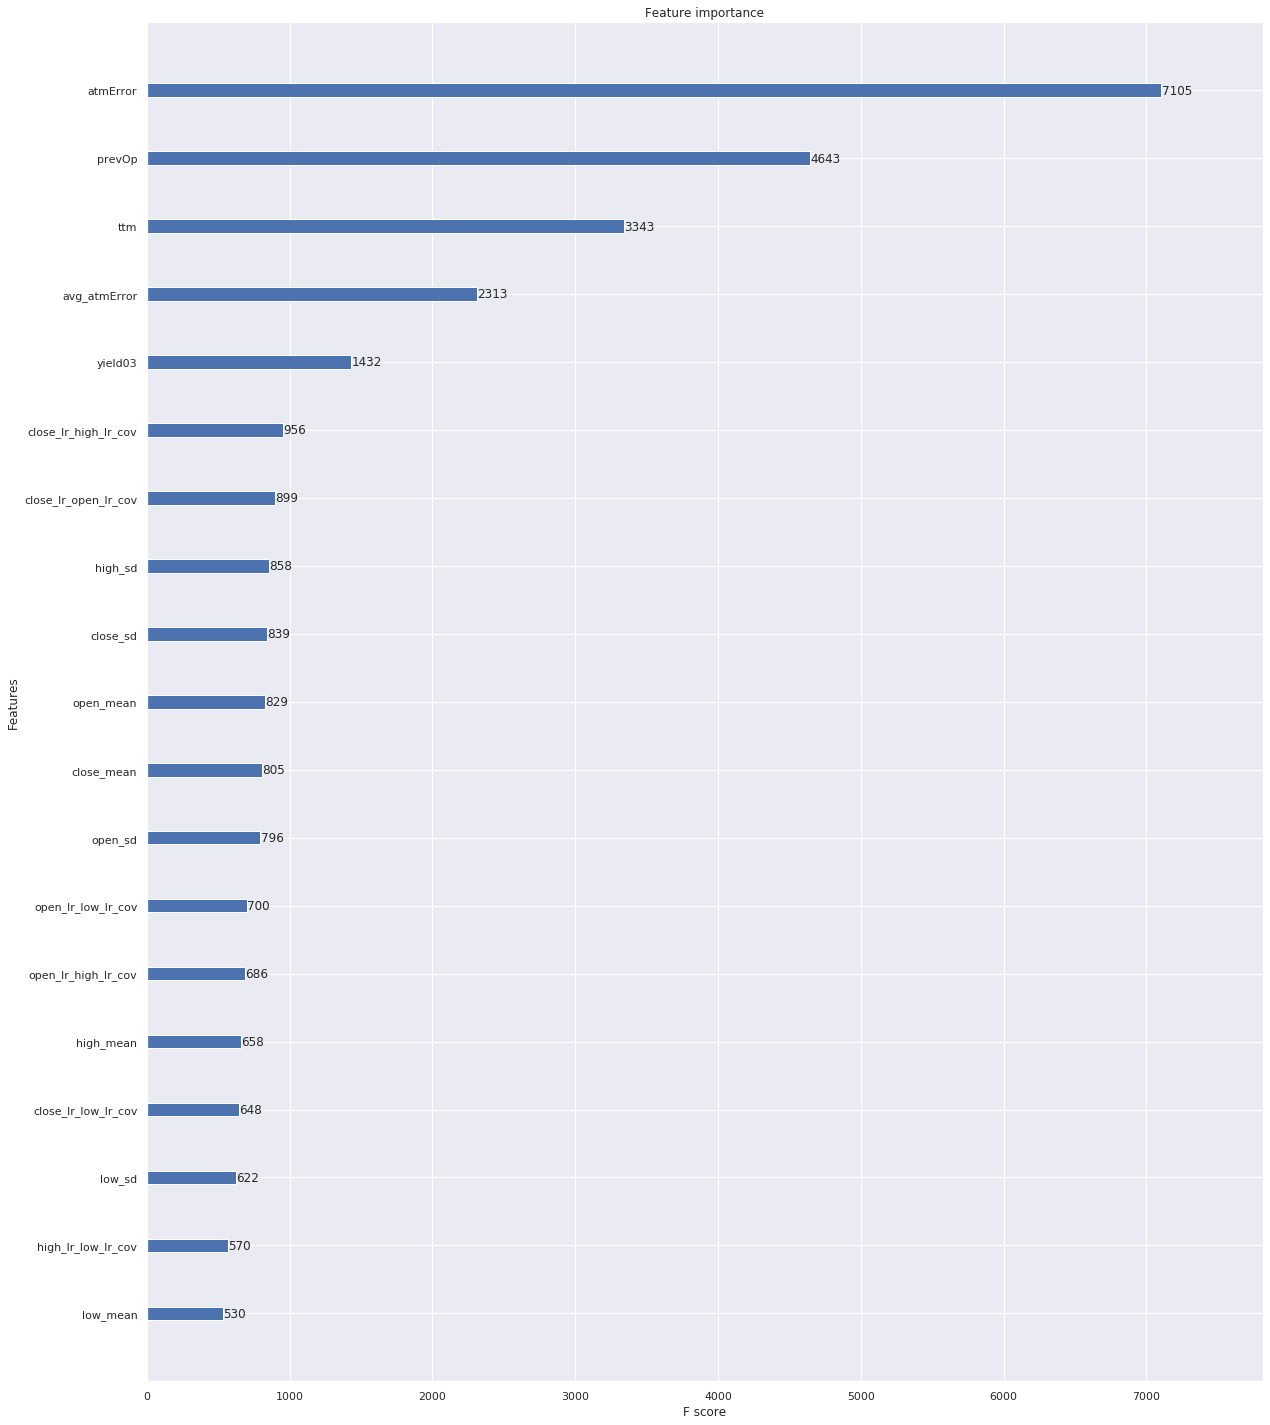

In [16]:
plt.rcParams['figure.figsize'] = [20, 25]
plot_importance(model)
plt.show()

# Port Part

In [58]:
model = joblib.load(modelpath +'NF+BNF3.model')

In [59]:
k = model.predict(X_test)
# Normalized Error Metric (NEM)
diff = []
bin_width = 0.1    # Note the uniform binning!!!!!!!!
dist_sum = 0
for i in range(len(k)):
    dist = abs(k[i] - Y_test[i])
    d = k[i] - Y_test[i]
    diff.append(d)
    dist_sum = dist_sum + dist
    
print("NEM :: ", (dist_sum*bin_width)/len(Y_test))

NEM ::  0.19798432250839865


In [60]:
accuracy_score(Y_test, k)*100
# print(classification_report(Y_test, k))

25.12131392310564

In [61]:
# Confidence interval value
lst = Y_test - k
round(1-c_int(lst)/100, 2)

KeyError: 0

In [44]:
# model = joblib.load(modelpath +'NIFTY50_Expt3.model')

In [51]:
# import datetime
# feats['date'] = pd.to_datetime(feats['date'])
# test=feats[(feats['date']>=datetime.datetime(2017,10,1))]
# split_val = test.index[0]

# X_train = X.iloc[0:split_val, :]
# X_test = X.iloc[split_val:, :]
# Y_train = Y[:split_val]
# Y_test = Y[split_val:]
# Y_test = Y_test.reset_index(drop = True)
# print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
# print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)


X & Y_Dim of Train is (10837, 19) (10837,)
X & Y_Dim of Test is (2679, 19) (2679,)


In [52]:
# Y_test

0       22
1       12
2        1
3        1
4        2
        ..
2674    13
2675     6
2676     7
2677    18
2678    24
Name: Target, Length: 2679, dtype: int64

In [53]:
# k = model.predict(X_test)
# # Normalized Error Metric (NEM)
# diff = []
# bin_width = 0.1    # Note the uniform binning!!!!!!!!
# dist_sum = 0
# for i in range(len(k)):
#     dist = abs(k[i] - Y_test[i])
#     d = k[i] - Y_test[i]
#     diff.append(d)
#     dist_sum = dist_sum + dist
    
# print("NEM :: ", (dist_sum*bin_width)/len(Y_test))

NEM ::  0.15923852183650616


In [54]:
# accuracy_score(Y_test, k)*100
# # print(classification_report(Y_test, k))

27.622247107129528

In [57]:
# # Confidence interval value
# lst = Y_test - k
# # round(1-c_int(lst)/100, 2)
# lst

In [17]:
# ### Begin Port Part


# b_feats['date'] = pd.to_datetime(b_feats['date'])
# test = b_feats[(b_feats['date']>=datetime.date(2017, 10,1))]
# split_val = test.index[0]

# ind = split_val


# b_X = b_feats.iloc[ind:,:-1]
# b_Y = b_feats.loc[ind:,'Target']
# b_X = b_X.drop(dropNames, axis = 1)

# # Scale the dataset according to saved scaler

# featNames = list(b_X)
# b_X = scaler.transform(b_X)
# b_X = pd.DataFrame(b_X, columns = featNames)


# # Split the dataset


# b_X_test = b_X.iloc[:, :]
# b_Y_test = b_Y.iloc[:]
# print ('b_X & b_Y_Dim of Test is', b_X_test.shape, b_Y_test.shape)

# b_Y_test = b_Y_test.values

In [18]:
# pred = model.predict(b_X_test)

In [19]:
# dist_sum = 0
# for i in range(len(pred)):
#     dist = abs(pred[i] - b_Y_test[i])
#     dist_sum = dist_sum + dist
    
# print("NEM ::", (dist_sum*bin_width)/len(b_Y_test))

In [20]:
# # Confidence interval value
# lst = b_Y_test - pred
# c_int(lst)

In [21]:
# b_feats